In [27]:
import pandas as pd 
import numpy as np
from datetime import datetime
from typing import Tuple, List
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

base_path = 'D:/dneuro/research/data/'
output_path = 'D:/dneuro/research/output/summary/NSL2/'

df_index = pd.read_excel(base_path + '/tpx500_historical_total_return_2000_2025_20250318.xlsx', index_col = 0)
df_return = pd.read_pickle(base_path + '/tpx500_historical_total_return_2000_2025_0318.pkl')
df_fx = pd.read_pickle(base_path + '/tpx500_msfxjpy_index_price_2000_2025.pkl')

df_index.columns = ['return']
df_index *= 0.01

df_return = df_return.reindex(sorted(df_return.columns, key=str), axis=1)

df_fx.columns = ['MSFXJPY Index']
df_fx['pct_change'] = df_fx['MSFXJPY Index'].pct_change()

def calculate_rolling_beta(fundData: pd.DataFrame, marketData: pd.DataFrame, rolling_period: int) -> pd.DataFrame:
    fundData.index = pd.to_datetime(fundData.index)
    marketData.index = pd.to_datetime(marketData.index)
    common_dates = list(fundData.index.intersection(marketData.index))
    # common_dates = [a for a in common_dates if a <= eval_date]
    adj_fund_data_lst = []
    beta_lst = []
    
    for x in range(len(common_dates)):

        if x < rolling_period - 1:

            beta = 1
            adj_fund_data_lst.append(fundData.loc[common_dates[x]] / beta)
            beta_lst.append(beta)

        else:

            spot_beta_period = common_dates[x - rolling_period + 1:x+1]
        
            fund_spot_data = fundData[fundData.index.isin(spot_beta_period)]
            market_spot_data = marketData[marketData.index.isin(spot_beta_period)]
            # print(fund_spot_data)
            # print(market_spot_data)
            covariance = np.cov(fund_spot_data.values.flatten(), market_spot_data.values.flatten())
            variance = np.var(market_spot_data.values.flatten())
            beta = covariance[0,1] / variance
            # adj_fund_data_lst.append(fund_spot_data.loc[common_dates[x]] - beta * market_spot_data.loc[common_dates[x]])
            beta_lst.append(beta)

    # df_adj_stock_data = pd.DataFrame(adj_fund_data_lst, index = common_dates) 
    df_beta = pd.DataFrame({'beta': beta_lst}, index = common_dates)
    return df_beta

def build_usd_return(df_fx: pd.DataFrame, df_return: pd.DataFrame) -> pd.DataFrame:

    common_dates = df_fx.index.intersection(df_return.index)

    df_fx_filtered = df_fx.loc[common_dates]

    df_return_filtered = df_return.loc[common_dates]

    tickers = df_return.columns.tolist()
    df_fx_filtered['pct_change_plus_1'] = df_fx_filtered['pct_change'] + 1

    df_return_filtered = (1+df_return_filtered).multiply(df_fx_filtered['pct_change_plus_1'], axis=0) - 1
    df_return_filtered = df_return_filtered[tickers]
    return df_return_filtered


def build_same_setting_dataframe(df_a: pd.DataFrame, df_b: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]: 
    # Find common tickers using set intersection (faster than list comprehension)
    common_tickers = sorted(set(df_a.columns) & set(df_b.columns))

    # Select only common tickers in sorted order
    return df_a[common_tickers], df_b[common_tickers]

def calc_portfolio_return(df_return: pd.DataFrame, df_factor: pd.DataFrame, lagging: int = 0)-> pd.DataFrame:

    df_weight_mul_return = df_factor * df_return.shift(-lagging)
    df_portfolio_return = df_weight_mul_return.sum(axis=1)
    df_portfolio_return = df_portfolio_return.shift(lagging)
    df_portfolio_return = pd.DataFrame(df_portfolio_return, columns = ['return'], index = df_portfolio_return.index)

    return df_portfolio_return

df_usd_return = build_usd_return(df_fx, df_return)
df_usd_return.index = pd.to_datetime(df_usd_return.index)

In [ ]:
# Universe: Topix 500 Constituents Only
# Trade Value Filter: Average Trade Value of USD 5M
# Main Data: Japan Securities Lending 
# Average number of Holdings: between 400 and 450
# Average daily turnover: about 29.5%
# recent 10-year sharpe ratio / recent 15-year sharpe ratio: 1.26 / 1.17
# Target Portfolio Size: 20M USD (1% of average trade value * 400 holdings)

In [29]:
df_factor1 = pd.read_excel(output_path + 'NSL2_factor1_ver2_weights.xlsx', index_col=0)
df_factor2 = pd.read_excel(output_path + 'NSL2_factor2_ver2_weights.xlsx', index_col=0)

common_dates = df_factor1.index \
.intersection(df_factor2.index) 

df_factor1 = df_factor1.loc[common_dates]
df_factor2 = df_factor2.loc[common_dates]

common_dates = df_usd_return.index.intersection(df_factor1.index)
df_factor1 = df_factor1.loc[common_dates]
df_usd_return_filtered = df_usd_return.loc[common_dates]
df_usd_return_filtered, df_factor1 = build_same_setting_dataframe(df_usd_return_filtered, df_factor1)
df_factor1_return = calc_portfolio_return(df_usd_return_filtered, df_factor1, 1)

common_dates = df_usd_return.index.intersection(df_factor2.index)
df_factor2 = df_factor2.loc[common_dates]
df_usd_return_filtered = df_usd_return.loc[common_dates]
df_usd_return_filtered, df_factor2 = build_same_setting_dataframe(df_usd_return_filtered, df_factor2)
df_factor2_return = calc_portfolio_return(df_usd_return_filtered, df_factor2, 1)

df_returns = pd.concat([df_factor1_return['return'], df_factor2_return['return']], axis=1)
df_returns.index = df_factor1_return.index
df_corr = df_returns.corr()
df_corr.columns = ['factor1','factor2']
df_corr.index = ['factor1','factor2']
df_corr

,factor1,factor2
factor1,1.000000,0.717984
factor2,0.717984,1.000000


(5256, 679) (5256, 679)
Strategy recent 20-year Sharpe Ratio:  1.22
Strategy recent 15-year Sharpe Ratio:  1.5
Strategy recent 10-year Sharpe Ratio:  1.67
TOPIX500 recent 20-year Sharpe Ratio:  0.41
TOPIX500 recent 15-year Sharpe Ratio:  0.6
TOPIX500 recent 10-year Sharpe Ratio:  0.58
Strategy recent 15-year Total Return:  0.4391
Strategy recent 10-year Total Return:  0.2997
TOPIX500 recent 15-year Total Return:  3.2467
TOPIX500 recent 10-year Total Return:  1.4979


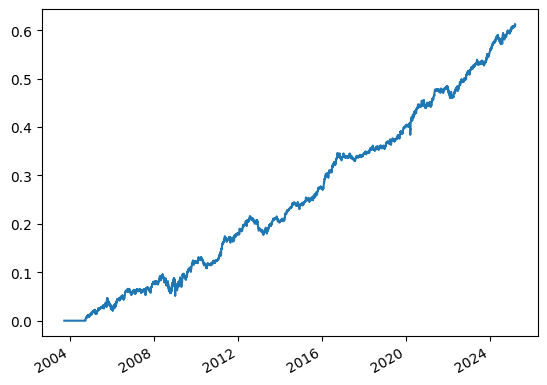

In [30]:
df_factor1 = pd.read_excel(output_path + 'NSL2_factor1_ver2_weights.xlsx', index_col=0)
df_factor2 = pd.read_excel(output_path + 'NSL2_factor2_ver2_weights.xlsx', index_col=0)

df_factor1.index = pd.to_datetime(df_factor1.index)
df_factor2.index = pd.to_datetime(df_factor2.index)
df_index.index = pd.to_datetime(df_index.index)

common_dates = df_factor1.index \
.intersection(df_factor2.index) \
.intersection(df_index.index)

df_factor1 = df_factor1.loc[common_dates]
df_factor2 = df_factor2.loc[common_dates]
df_index = df_index.loc[common_dates]

print(df_factor1.shape, df_factor2.shape)

df_weights = df_factor1.mul(0.5).add(df_factor2.mul(0.5), fill_value=0)

common_dates = df_usd_return.index.intersection(df_weights.index)
df_weights = df_weights.loc[common_dates]
df_usd_return_filtered = df_usd_return.loc[common_dates]

df_usd_return_filtered, df_weights = build_same_setting_dataframe(df_usd_return_filtered, df_weights)
df_portfolio_return = calc_portfolio_return(df_usd_return_filtered, df_weights, 1)

((df_portfolio_return['return'] + 1).cumprod() - 1).plot()
print('Strategy recent 20-year Sharpe Ratio: ', round((df_portfolio_return.loc[datetime.strptime('20050101','%Y%m%d'):]['return'].mean()*250) / (df_portfolio_return.loc[datetime.strptime('20050101','%Y%m%d'):]['return'].std() * np.sqrt(250)),2))
print('Strategy recent 15-year Sharpe Ratio: ', round((df_portfolio_return.loc[datetime.strptime('20100101','%Y%m%d'):]['return'].mean()*250) / (df_portfolio_return.loc[datetime.strptime('20100101','%Y%m%d'):]['return'].std() * np.sqrt(250)),2))
print('Strategy recent 10-year Sharpe Ratio: ', round((df_portfolio_return.loc[datetime.strptime('20150101','%Y%m%d'):]['return'].mean()*250) / (df_portfolio_return.loc[datetime.strptime('20150101','%Y%m%d'):]['return'].std() * np.sqrt(250)),2))

print('TOPIX500 recent 20-year Sharpe Ratio: ', round((df_index.loc[datetime.strptime('20050101','%Y%m%d'):]['return'].mean()*250) / (df_index.loc[datetime.strptime('20050101','%Y%m%d'):]['return'].std() * np.sqrt(250)),2))
print('TOPIX500 recent 15-year Sharpe Ratio: ', round((df_index.loc[datetime.strptime('20100101','%Y%m%d'):]['return'].mean()*250) / (df_index.loc[datetime.strptime('20100101','%Y%m%d'):]['return'].std() * np.sqrt(250)),2))
print('TOPIX500 recent 10-year Sharpe Ratio: ', round((df_index.loc[datetime.strptime('20150101','%Y%m%d'):]['return'].mean()*250) / (df_index.loc[datetime.strptime('20150101','%Y%m%d'):]['return'].std() * np.sqrt(250)),2))

print('Strategy recent 15-year Total Return: ', round(((df_portfolio_return.loc[datetime.strptime('20100101','%Y%m%d'):]['return'] + 1).cumprod() - 1).iloc[-1],4))
print('Strategy recent 10-year Total Return: ', round(((df_portfolio_return.loc[datetime.strptime('20150101','%Y%m%d'):]['return'] + 1).cumprod() - 1).iloc[-1],4))

print('TOPIX500 recent 15-year Total Return: ', round(((df_index.loc[datetime.strptime('20100101','%Y%m%d'):]['return'] + 1).cumprod() - 1).iloc[-1],4))
print('TOPIX500 recent 10-year Total Return: ', round(((df_index.loc[datetime.strptime('20150101','%Y%m%d'):]['return'] + 1).cumprod() - 1).iloc[-1],4))


<Axes: >

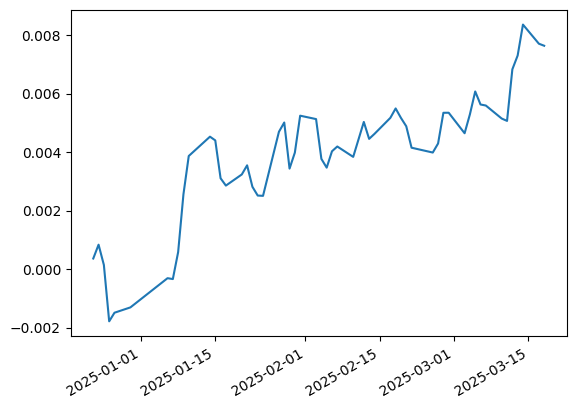

In [31]:
((df_portfolio_return['return'].tail(55) + 1).cumprod() - 1).plot()

# Number of Holdings

<Axes: >

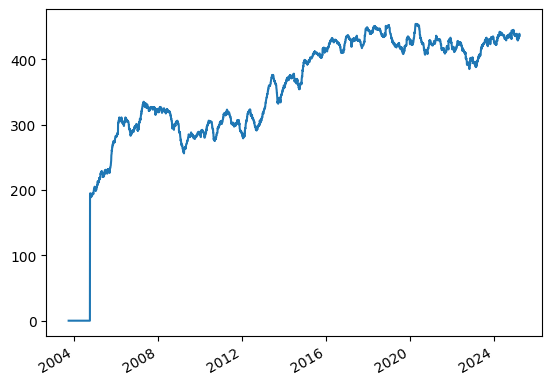

In [32]:
df_weights_filtered = df_weights.dropna(how='all')
df_weights_count = (df_weights_filtered != 0).astype(int).sum(axis=1) 
df_weights_count.plot()

# Portfolio Weight

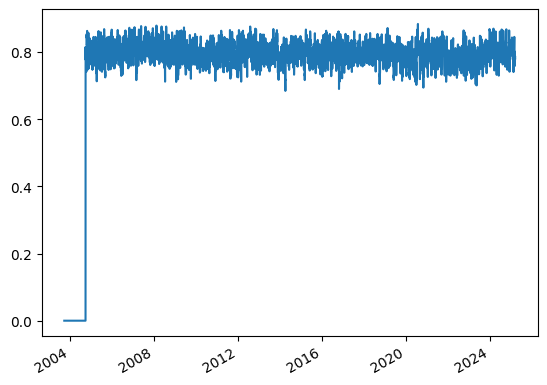

In [33]:
df_portfolio_weights = df_weights.abs().sum(axis=1).plot()

# Portfolio Turnover

0.2908695635080527


<Axes: >

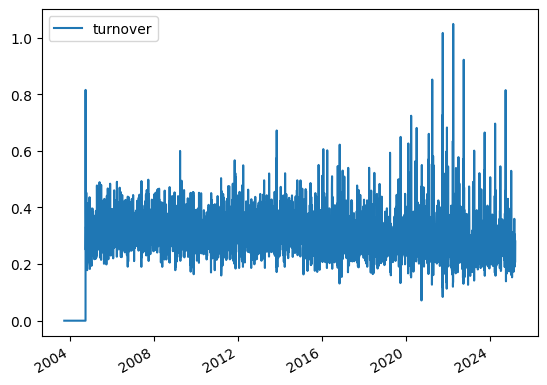

In [34]:
df_turnover = df_weights.fillna(0).diff().abs().sum(axis=1)
df_turnover = pd.DataFrame(df_turnover, columns = ['turnover'])
print(df_turnover['turnover'].mean())
df_turnover.plot()

# Fee Adjusted Return

Strategy recent 15-year Sharpe Ratio:  1.04
Strategy recent 10-year Sharpe Ratio:  1.21
Strategy recent 15-year Total Return:  0.2873
Strategy recent 10-year Total Return:  0.2089


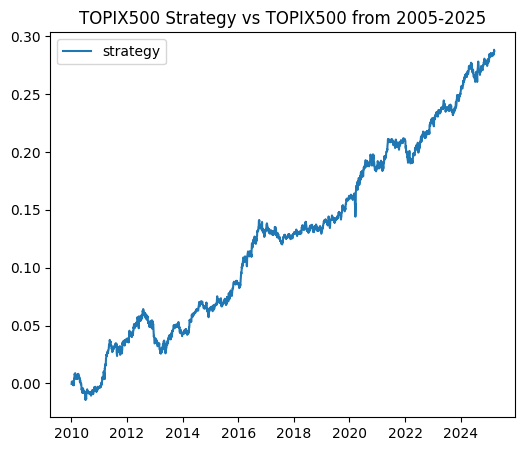

In [35]:

df_portfolio_return['adj_return'] = df_portfolio_return['return'] - df_turnover['turnover'] * 0.0001

# print((df_portfolio_return.loc[datetime.strptime('20050101','%Y%m%d'):]['adj_return'].mean()*250) / (df_portfolio_return.loc[datetime.strptime('20050101','%Y%m%d'):]['adj_return'].std() * np.sqrt(250)))
print('Strategy recent 15-year Sharpe Ratio: ', round((df_portfolio_return.loc[datetime.strptime('20100101','%Y%m%d'):]['adj_return'].mean()*250) / (df_portfolio_return.loc[datetime.strptime('20100101','%Y%m%d'):]['adj_return'].std() * np.sqrt(250)),2))
print('Strategy recent 10-year Sharpe Ratio: ', round((df_portfolio_return.loc[datetime.strptime('20150101','%Y%m%d'):]['adj_return'].mean()*250) / (df_portfolio_return.loc[datetime.strptime('20150101','%Y%m%d'):]['adj_return'].std() * np.sqrt(250)),2))

print('Strategy recent 15-year Total Return: ', round(((df_portfolio_return.loc[datetime.strptime('20100101','%Y%m%d'):]['adj_return'] + 1).cumprod() - 1).iloc[-1],4))
print('Strategy recent 10-year Total Return: ', round(((df_portfolio_return.loc[datetime.strptime('20150101','%Y%m%d'):]['adj_return'] + 1).cumprod() - 1).iloc[-1],4))

fig = plt.figure(figsize=(6, 5))

plt.plot((df_portfolio_return.loc[datetime.strptime('20100101','%Y%m%d'):]['adj_return'] + 1).cumprod() - 1, label = 'strategy')
# plt.plot((df_index.loc[datetime.strptime('20100101','%Y%m%d'):]['return'] + 1).cumprod() - 1, label = 'TOPIX500')

plt.title('TOPIX500 Strategy vs TOPIX500 from 2005-2025')
plt.legend()
plt.show() 

# Beta Adjusted Return

Strategy recent 15-year Sharpe Ratio:  1.17
Strategy recent 10-year Sharpe Ratio:  1.26
Strategy recent 15-year Total Return:  0.3156
Strategy recent 10-year Total Return:  0.21


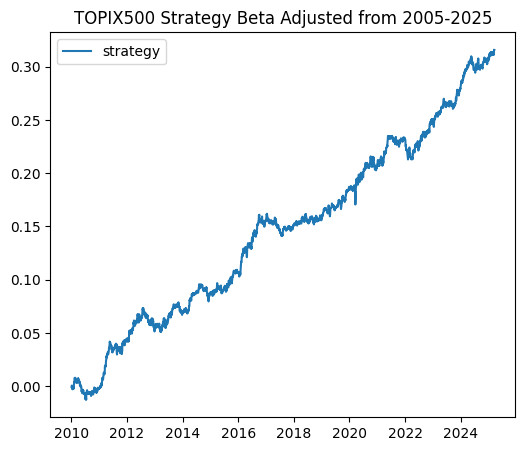

In [36]:
df_portfolio_adj_return = df_portfolio_return[['adj_return']].fillna(0)

df_beta = calculate_rolling_beta(df_portfolio_adj_return, df_index, 60)

df_portfolio_adj_return['beta_adj_return'] = df_portfolio_adj_return['adj_return'] - df_beta['beta'] * df_index['return']
print('Strategy recent 15-year Sharpe Ratio: ',round((df_portfolio_adj_return.loc[datetime.strptime('20100101','%Y%m%d'):]['beta_adj_return'].mean()*250) / (df_portfolio_adj_return.loc[datetime.strptime('20100101','%Y%m%d'):]['beta_adj_return'].std() * np.sqrt(250)),2))
print('Strategy recent 10-year Sharpe Ratio: ',round((df_portfolio_adj_return.loc[datetime.strptime('20150101','%Y%m%d'):]['beta_adj_return'].mean()*250) / (df_portfolio_adj_return.loc[datetime.strptime('20150101','%Y%m%d'):]['beta_adj_return'].std() * np.sqrt(250)),2))

print('Strategy recent 15-year Total Return: ', round(((df_portfolio_adj_return.loc[datetime.strptime('20100101','%Y%m%d'):]['beta_adj_return'] + 1).cumprod() - 1).iloc[-1],4))
print('Strategy recent 10-year Total Return: ', round(((df_portfolio_adj_return.loc[datetime.strptime('20150101','%Y%m%d'):]['beta_adj_return'] + 1).cumprod() - 1).iloc[-1],4))

fig = plt.figure(figsize=(6, 5))

plt.plot((df_portfolio_adj_return.loc[datetime.strptime('20100101','%Y%m%d'):]['beta_adj_return'] + 1).cumprod() - 1, label = 'strategy')

plt.title('TOPIX500 Strategy Beta Adjusted from 2005-2025')
plt.legend()
plt.show() 